In [58]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits import mplot3d

(120, 120, 3)


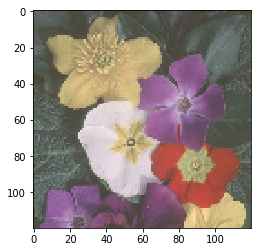

In [59]:
img=mpimg.imread('../data/flowersm.ppm')
print(img.shape)
imgplot = plt.imshow(img)

In [60]:
# convert image to features

def img_to_features(img):
    
    IMG_DIM = 120
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    features = []
    for i in range(IMG_DIM):
        for j in range(IMG_DIM):
            features.append([r[i,j], g[i,j], b[i,j]])
    features = np.array(features)
    
    return features

features = img_to_features(img)

In [61]:
# find min and max rgb values of original image
INT_MIN = np.min(features.flatten())
INT_MAX = np.max(features.flatten())

In [62]:
print(features)
print(features.shape)

[[100 106 106]
 [104 110 110]
 [104 110 110]
 ...
 [ 95 104  87]
 [ 91 100  83]
 [ 82  91  74]]
(14400, 3)


In [63]:
# function for calculating Euclidean distance
def euc_dist(x, y):
    
    diff = x-y
    
    if(diff.ndim == 1):
        return np.abs(diff)
    
    return np.linalg.norm(diff, axis = 1)

# function for k-means clustering
def kmeans(X, k=256):
    
    # initialize means and indices
    prev_k_means = np.array([[0 for i in range(3)] for j in range(k)])
    means = np.array([[np.random.randint(INT_MIN, INT_MAX) for i in range(3)] for j in range(k)])
    indices = np.array([ind for ind in range(len(X))])
    
    count = 0
    nearest_means = []
    # continue iterations until cluster assignments stop changing or max iterations exceeded
    while not np.array_equal(prev_k_means, means) and count < 1000: 
        count += 1
        nearest_means = []
        
        # find nearest centroid for each sample
        for x in X:
            s = euc_dist(means, x)
            nearest_means.append(np.argmin(s))
        nearest_means = np.array(nearest_means)
        prev_k_means = means
        means = np.array([[0,0,0] for i in range(k)])
        
        # update centroids to average of means in cluster
        for k_ in range(k):
            cluster = X[nearest_means[:]==k_]
            if len(cluster) == 0:
                means[k_] = prev_k_means[k_]
            else:
                means[k_] = np.array([np.mean(cluster, axis=0)])

    means = np.array([[int(np.round(means[j,i])) for i in range(3)] for j in range(k)])
    return nearest_means, means

def silhouette_score(X, nearest_means, means, k=256):
    
    scores = []
    for i in range(len(nearest_means)):
        # calculate A
        cluster = X[nearest_means[:]==nearest_means[i]]
        if len(cluster) == 0:
            a = 0.0
        else:
            a = np.mean(euc_dist(cluster, X[i]), axis = 0)

        # calculate B
        indices = [j for j in range(k)]
        dists = euc_dist(X[i], means)
        s = np.column_stack((indices, dists))
        s = s[s[:,1].argsort()]
        
        # get second nearest cluster
        cluster_ind = int(s[1,0])
        cluster = cluster = X[nearest_means[:]==nearest_means[cluster_ind]]
        if len(cluster) == 0:
            b = 0.0
        else:
            b = np.mean(euc_dist(cluster, X[i]), axis = 0)
        
        if max(a,b) == 0:
            score = 0.0
        else:
            score = (b-a)/max(a,b)
        scores.append(score)
    return np.mean(score)

def calculate_error(features, nearest_means, means):
    new_features = []
    for i in range(len(nearest_means)):
        new_features.append(means[nearest_means[i]])
    new_features = np.array(new_features)
    return np.square(np.subtract(features, new_features)).mean()

# run for k = 256
nearest_means, means = kmeans(features, k=256)
print(calculate_error(features, nearest_means, means))

16.44349537037037


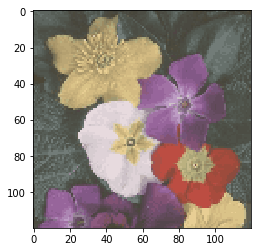

In [65]:
# convert means and cluster assignments back to image
def means_to_img(means, nearest_means, filename):

    new_r = []
    new_g = []
    new_b = []

    IMG_DIM = 120
    for i in range(IMG_DIM):
        new_r_row = []
        new_g_row = []
        new_b_row = []
        for j in range(IMG_DIM):
            new_r_row.append(means[nearest_means[i*IMG_DIM+j],0])
            new_g_row.append(means[nearest_means[i*IMG_DIM+j],1]) 
            new_b_row.append(means[nearest_means[i*IMG_DIM+j],2])
        new_r.append(new_r_row)
        new_g.append(new_g_row)
        new_b.append(new_b_row)

    new_img = np.stack(np.array([new_r, new_g, new_b]), axis=2)
    plt.imshow(new_img)
    plt.savefig(filename)
    
means_to_img(means, nearest_means, 'figures/k_means_256.png')

[740.2229629629629, 325.6433564814815, 172.2553472222222, 68.89324074074074, 56.44997685185185, 36.72277777777778, 22.180393518518517, 17.169907407407408]


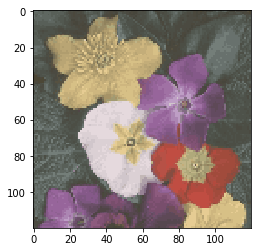

In [66]:
scores = []
ks = [2,4,8,16,32,64,128,256]
for k_ in ks:
    nearest_means, means = kmeans(features, k=k_)
    means_to_img(means, nearest_means, 'figures/kmeans_' + str(k_) + '.png')
    scores.append(calculate_error(features, nearest_means, means))
print(scores)

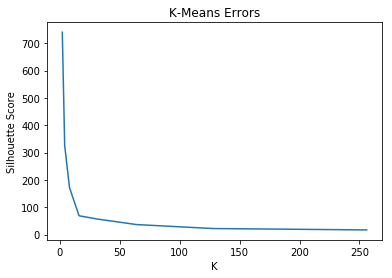

In [67]:
# plot silhouette scores
def plot_error(k, scores, title, xlabel, ylabel, filename):
    
    plt.plot(k, scores)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(filename)
    
plot_error(ks, scores, 'K-Means Errors', 'K', 'Silhouette Score', 'figures/kmeans_errors.png')

In [68]:
# winner take all algorithm
def winner_take_all(X, epsilon=0.01, k=256):
    
    #initialize centroids and indices
    prev_nearest_means = np.array([0 for j in range(len(X))])
    nearest_means = np.array([1 for j in range(len(X))])
    means = np.array([[np.random.uniform(INT_MIN, INT_MAX) for i in range(3)] for j in range(k)])
    indices = np.array([ind for ind in range(k)])
    
    
    count = 0
    # continue iterations until cluster assignments stop changing or max iterations exceeded
    while not np.array_equal(prev_nearest_means, nearest_means) and count < 1000:
        prev_nearest_means = np.copy(nearest_means)
        count += 1
        for i in range(len(X)):
            
            # find nearest centroid
            dists = euc_dist(means, X[i])
            s = np.column_stack((indices, dists))
            s = s[s[:,1].argsort()]
            cluster_ind = int(s[0,0])
            
            # use sample to update centroid and assign sample to cluster
            means[cluster_ind] = means[cluster_ind] + epsilon*(np.subtract(X[i], means[cluster_ind])) 
            nearest_means[i] = cluster_ind
            
    means = np.array([[int(np.round(means[j,i])) for i in range(3)] for j in range(k)])
    return np.array(nearest_means), means

# run for k = 256
nearest_means, means = winner_take_all(features, epsilon=0.01, k=256)
print('Mean Squared Error', calculate_error(features, nearest_means, means))

Mean Squared Error 16.381319444444443


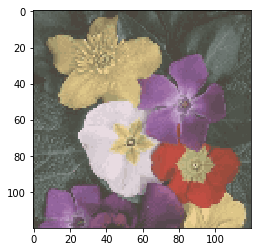

In [69]:
means_to_img(means, nearest_means, 'figures/winner_take_all_256.png')

[824.632662037037, 855.4044675925926, 244.57085648148148, 164.02689814814815, 64.55217592592592, 61.47988425925926, 40.89407407407408, 18.603680555555556]


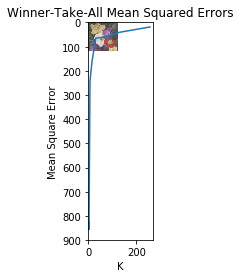

In [70]:
ks = [2,4,8,16,32,64,128,256]
scores = []
for k_ in ks:
    nearest_means, means = winner_take_all(features, epsilon=0.01, k=k_)
    means_to_img(means, nearest_means, 'figures/wta_' + str(k_) + '.png')
    scores.append(calculate_error(features, nearest_means, means))
print(scores)
plot_error(ks, scores, 'Winner-Take-All Mean Squared Errors', 'K', 'Mean Square Error', 'figures/wta_error.png')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Error 41.29453703703704


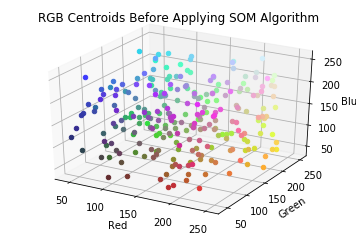

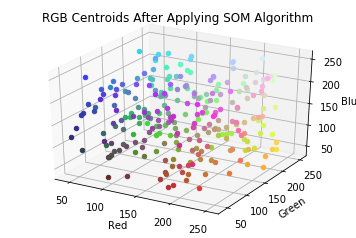

In [71]:
def plot_means(means, k, title):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    means = np.array([[int(np.round(means[j,i])) for i in range(3)] for j in range(k)])
    for i in range(len(means)):
        ax.scatter3D(means[i,0], means[i,1], means[i,2], c=means[i]/255.0)
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('RGB Centroids ' + title + ' Applying SOM Algorithm')
    fig.savefig(title+'.png')

def som(X, sigma=2.0, e_min=0.0001, e_max=0.15, k=256):
    
    max_it = 100
    
    prev_nearest_means = np.array([0 for j in range(len(X))])
    nearest_means = np.array([1 for j in range(len(X))])
    means = np.array([[np.random.uniform(INT_MIN, INT_MAX) for i in range(3)] for j in range(k)])
    indices = np.array([ind for ind in range(k)])
    
    # initialize means in grid formation
    sqrt_k = int(np.ceil(np.sqrt(k)))
    means = np.array(means)
    #g = np.array(g)
    #means = np.array([[np.random.uniform(INT_MIN, INT_MAX) for i in range(3)] for j in range(k)])
    #means = np.array([[int(np.round(means[j,i])) for i in range(3)] for j in range(k)])
    plot_means(means, k, 'Before')
    
    count = 0
    while not np.array_equal(prev_nearest_means, nearest_means) and count < max_it:#000:
        prev_nearest_means = np.copy(nearest_means)
        
        count += 1
        print(count)
        for i in range(0, len(X)):
            
            dists = euc_dist(means, X[i])
            
            s = np.column_stack((indices, dists))
            s = s[s[:,1].argsort()]
            
            # get nearest cluster
            cluster_ind = int(s[0,0])
            
            s = s[s[:,1] <= sigma]
            
            cluster_i = np.floor(cluster_ind/sqrt_k)
            cluster_j = cluster_ind%sqrt_k
            
            e_k = e_max*(e_min/e_max)**(count/max_it)
            
            for j in range(len(s)):
                phi = np.exp(-np.linalg.norm(means[int(s[j,0])] - means[cluster_ind])**2/(2*sigma**2))
                means[int(s[j,0])] = means[int(s[j,0])] + e_k*phi*(np.subtract(X[i], means[cluster_ind])) 
            
            nearest_means[i] = cluster_ind
        
    means = np.array([[int(np.round(means[j,i])) for i in range(3)] for j in range(k)])
    plot_means(means, k, 'After')
    return np.array(nearest_means), means


# run for k = 256
nearest_means, means = som(features, sigma=10.0, e_min=0.0001, e_max=0.1, k=256)
print('Error', calculate_error(features, nearest_means, means))

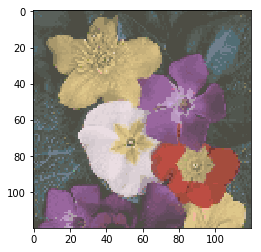

In [72]:
means_to_img(means, nearest_means, 'figures/som_256.png')

1
2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
1
2
3
4
5
6
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
[3961.472615740741, 1195.0955324074075, 671.3948842592592, 855.8349537037037, 332.53

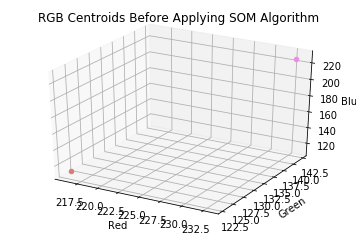

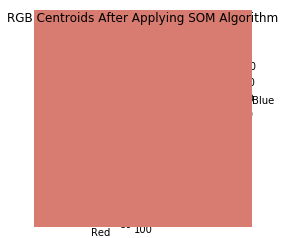

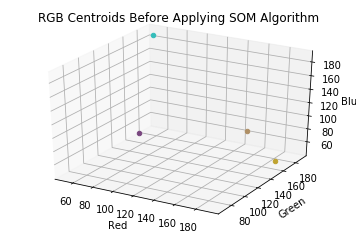

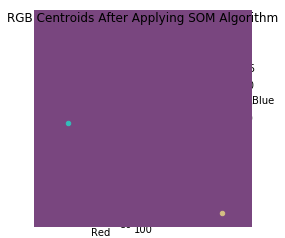

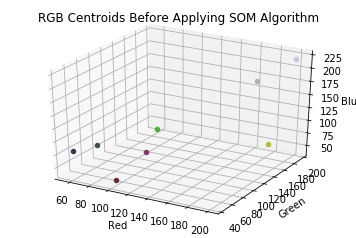

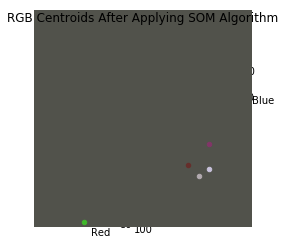

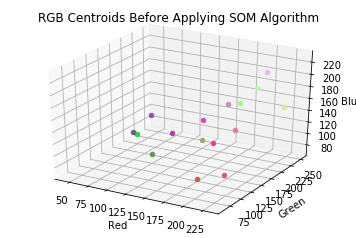

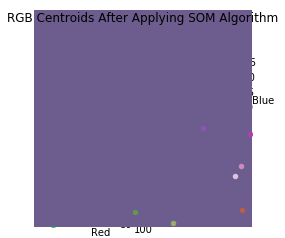

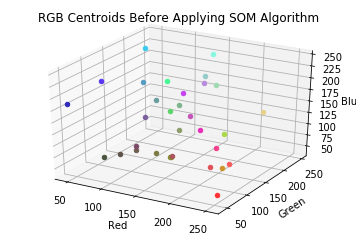

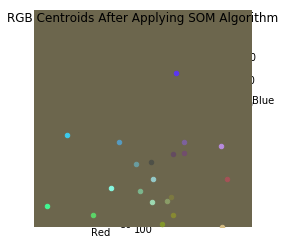

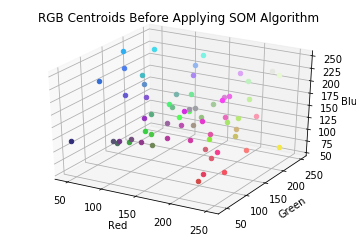

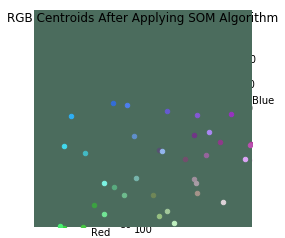

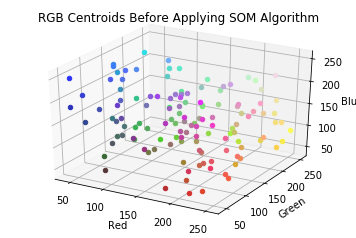

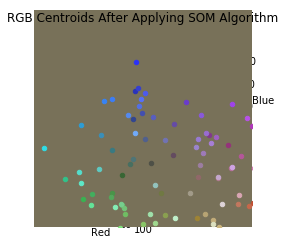

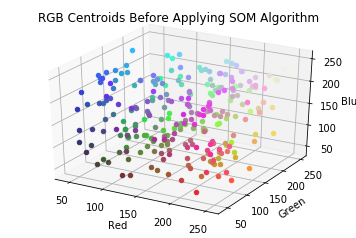

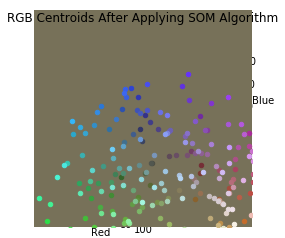

In [73]:
ks = [2,4,8,16,32,64,128,256]
scores = []
for k_ in ks:
    nearest_means, means = som(features, sigma=10.0, e_min=0.0001, e_max=0.1, k=k_)
    means_to_img(means, nearest_means, 'figures/som_' + str(k_) + '.png')
    scores.append(calculate_error(features, nearest_means, means))
print(scores)

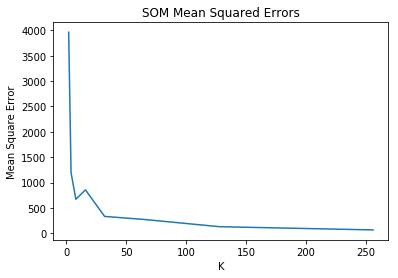

In [74]:
plot_error(ks, scores, 'SOM Mean Squared Errors', 'K', 'Mean Square Error', 'figures/som_errors.png')

In [76]:
# mean shift kernel function
def kernel(x, h):
    if np.linalg.norm(x) <= h:
        return 1.0
    else:
        return 0.0

# mean shift clustering function
def mean_shift(X, h, epsilon):
    
    X = np.copy(X)
    
    #X_old = np.array([[0.0 for i in range(3)] for j in range(len(X))])

    indices = np.array([float(ind) for ind in range(len(X))])
    
    # apply kernel function to all samples
    for i in range(0, len(X)):
        kernel(X[i], h)
                   
    #X_old = np.copy(X)
    for i in range(0, len(X)):
            
        if i%1000 == 0:
            print('i', i)
 
        count = 0
        while True:
                
            count += 1
            
            dists = euc_dist(X, X[i])

            s = np.column_stack((indices, dists))

            #sort by distance
            s = s[s[:,1].argsort()]
            s = s[s[:,1] <= h]

            num = np.array([0.0, 0.0, 0.0])
            denom = 0.0

            for j in range(len(s)):
                num += np.multiply(kernel(X[int(s[j,0])]-X[i], h), X[int(s[j,0])])
                denom += kernel(X[int(s[j,0])]-X[i], h)

            # shift x
            mean = num/denom
            
            # save difference between mean and x
            diff = np.linalg.norm(mean-X[i])
            X[i] = mean

            # break if diff exceeds epsilon
            if diff < epsilon or count > 100:
                break
    
    return X

print(features)
X = mean_shift(features, 2, 0.1)
print(features)

[[100 106 106]
 [104 110 110]
 [104 110 110]
 ...
 [ 95 104  87]
 [ 91 100  83]
 [ 82  91  74]]
i 0
i 1000
i 2000
i 3000
i 4000
i 5000
i 6000
i 7000
i 8000
i 9000
i 10000
i 11000
i 12000
i 13000
i 14000
[[100 106 106]
 [104 110 110]
 [104 110 110]
 ...
 [ 95 104  87]
 [ 91 100  83]
 [ 82  91  74]]


In [77]:
# convert means and cluster assignments back to image
def features_to_img(X, filename):

    new_r = []
    new_g = []
    new_b = []

    IMG_DIM = 120
    for i in range(IMG_DIM):
        new_r_row = []
        new_g_row = []
        new_b_row = []
        for j in range(IMG_DIM):
            new_r_row.append(X[i*IMG_DIM+j,0])
            new_g_row.append(X[i*IMG_DIM+j,1]) 
            new_b_row.append(X[i*IMG_DIM+j,2])
        new_r.append(new_r_row)
        new_g.append(new_g_row)
        new_b.append(new_b_row)

    new_img = np.stack(np.array([new_r, new_g, new_b]), axis=2)
    plt.imshow(new_img)
    plt.savefig(filename)

[[100 106 106]
 [104 110 110]
 [104 110 110]
 ...
 [ 95 104  87]
 [ 91 100  83]
 [ 82  91  74]]
66.93490740740741


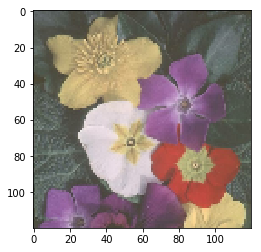

In [78]:
print(features)
print(calculate_error(features, nearest_means, means))
features_to_img(X, 'figures/mean_shift_2.png')

In [ ]:
hs = [i for i in range(2, 11, 2)]
scores = []
for h in hs:
    X = mean_shift(features, h, 0.1)
    means_to_img(means, nearest_means, 'figures/mean_shift_h_' + str(h) + '.png')
    scores.append(calculate_error(features, nearest_means, means))
    print(scores)

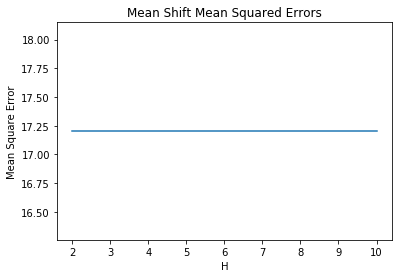

In [57]:
plot_error(hs, scores, 'Mean Shift Mean Squared Errors', 'H', 'Mean Square Error', '/figures/mean_shift_errors.png')